## Analysis of AssignmentCodes.sql Database in Pandas 

### Import dependencies and modules, especially sqlalchemy. Also setup the .gitignore and passwork file for db

In [2]:
#Use Pandas and potentially Numpy
import pandas as pd
import numpy as np
import os
import psycopg2
import matplotlib.pyplot as plt
from config import db_user
from config import db_password
from config import db_host
from config import db_port

#Import engine creation to connect to database 
from sqlalchemy import create_engine

In [3]:
#AssignmentsCodes.sql database is in the same directory. Note that this is a Postgresql database and postgresql:// is required.
#engine = create_engine('postgresql://localhost:5432/TablesCodes.sql')
#print(engine)

In [4]:
#Don't entirely understand this, but the engine creation requires variables to populate the database connection string.
#The connection string is in form postgres://DBUser:DBPassword#DBHost#:DBPort/DBName. Used config.py to protect db data.

# This database must already exist. This is the PostgreSQL DB and not the .sql file! 
db_name = "EmployeeSQL"

engine = create_engine(f"postgres://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

In [5]:
data = pd.read_sql("SELECT * FROM salaries", engine)

In [6]:
data.head()

,emp_no,salary,from_date,to_date,id
0,10001,60117,6/26/1986,6/26/1987,1
1,10002,65828,8/3/1996,8/3/1997,2
2,10003,40006,12/3/1995,12/2/1996,3
3,10004,40054,12/1/1986,12/1/1987,4
4,10005,78228,9/12/1989,9/12/1990,5


In [7]:
#Tried to make a binning approach for salary using the np.histogram, but error on
#"not supported between instances of 'str' and 'int'."" I suspect the data in 'salary' column are strings, not integers!
#Try creating the salaries list and iterating through dataframe, convering  to integers and appending to the list salaries.
salaries = []
for index, row in data.iterrows():
    salaries.append(int(row[1]))

In [22]:
#Check salaries entries to confirm data integrity.
salaries[:10]

[60117, 65828, 40006, 40054, 78228, 40000, 56724, 46671, 60929, 72488]

In [9]:
#From the WeatherPy assignemnt, I recall a histogram function in Numpy! Try using this and some
#legwork on finding the proper binning.
salary_bins = [30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000]
salary_counts = (np.histogram(salaries, salary_bins))
salary_counts

(array([     0, 158465,  57915,  41413,  24814,  11845,   4284,   1069,
           195,     24,      0], dtype=int64),
 array([ 30000,  40000,  50000,  60000,  70000,  80000,  90000, 100000,
        110000, 120000, 130000, 140000]))

Text(0, 0.5, 'Number of Employees')

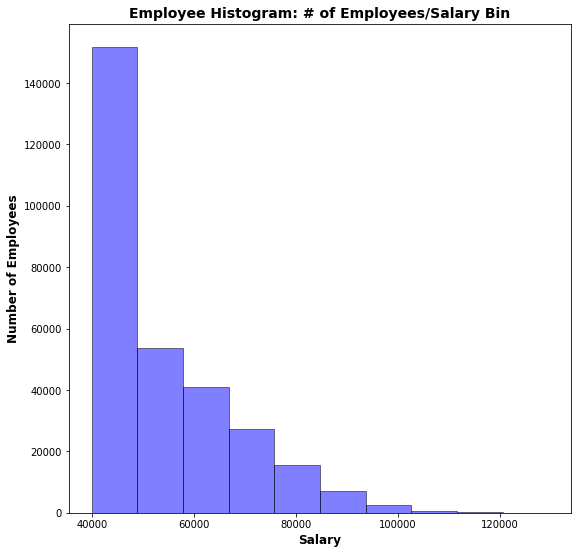

In [10]:
fig = plt.figure(figsize=(9,9))

num_bins = 10
n, bins, patches = plt.hist(salaries, num_bins, facecolor = 'b', edgecolor='k', alpha = 0.5)

plt.title('Employee Histogram: # of Employees/Salary Bin', fontsize=14, fontweight='bold')
plt.xlabel('Salary', fontsize=12, fontweight='bold')
plt.ylabel('Number of Employees', fontsize=12, fontweight='bold')

In [11]:
#Created new .sql table with salary and title information called bonus_table.
bonus_df = pd.read_sql('SELECT * FROM bonus_table', engine)
bonus_df.head()

,emp_no,salary,title
0,10003,40006,Senior Engineer
1,10035,41538,Engineer
2,10035,41538,Senior Engineer
3,10038,40000,Senior Staff
4,10038,40000,Staff


In [12]:
bonus_df.count()

emp_no    443308
salary    443308
title     443308
dtype: int64

In [13]:
#Minor problem. Salary database used salary = VARCHAR, not Integer! Have to convert to integer in a new salary column.
#Use iterrows() to iterate over bonus_df and make a new integer salary column for calculations. More optimized code would
#go back and regenerate table with integer salaries to resolve this problem.
bonus_df['salary_num'] = ''
bonus_df.head()

,emp_no,salary,title,salary_num
0,10003,40006,Senior Engineer,
1,10035,41538,Engineer,
2,10035,41538,Senior Engineer,
3,10038,40000,Senior Staff,
4,10038,40000,Staff,


In [14]:
#NOTE: tried direct input bonus_df['salary_num'] = int(row[1]) for iterrows, but very slow! Faster to generate salarylist,
#then assign bonus_df['salary_num'] = salarylist.
salarylist = []
for index, row in bonus_df.iterrows():
    salarylist.append(int(row[1]))

salarylist[:10]

[40006, 41538, 41538, 40000, 40000, 81662, 81662, 40919, 54982, 54982]

In [15]:
bonus_df['salary_num'] = salarylist
bonus_df.head(10)

,emp_no,salary,title,salary_num
0,10003,40006,Senior Engineer,40006
1,10035,41538,Engineer,41538
2,10035,41538,Senior Engineer,41538
3,10038,40000,Senior Staff,40000
4,10038,40000,Staff,40000
5,10042,81662,Senior Staff,81662
6,10042,81662,Staff,81662
7,10044,40919,Technique Leader,40919
8,10047,54982,Engineer,54982
9,10047,54982,Senior Engineer,54982


In [16]:
bonus_df.groupby('title').count()

,emp_no,salary,salary_num
title,,,
Assistant Engineer,15128,15128,15128
Engineer,115003,115003,115003
Manager,24,24,24
Senior Engineer,97750,97750,97750
Senior Staff,92853,92853,92853
Staff,107391,107391,107391
Technique Leader,15159,15159,15159


In [17]:
title_list = list(set(bonus_df['title'].values))
title_list

['Senior Engineer',
 'Assistant Engineer',
 'Staff',
 'Senior Staff',
 'Engineer',
 'Technique Leader',
 'Manager']

In [18]:
means = bonus_df.groupby('title').mean()

In [19]:
means

,salary_num
title,
Assistant Engineer,48493.204786
Engineer,48539.781423
Manager,51531.041667
Senior Engineer,48506.751806
Senior Staff,58503.286614
Staff,58465.271904
Technique Leader,48580.505772


In [20]:
#Import Scipy.stats to enable stdev calculation
errors = bonus_df.groupby('title').std()
errors

,salary_num
title,
Assistant Engineer,10247.593341
Engineer,10316.455234
Manager,12068.128725
Senior Engineer,10252.364539
Senior Staff,16505.512022
Staff,16499.346126
Technique Leader,10313.486129


Text(0, 0.5, 'Mean Salary ($US)')

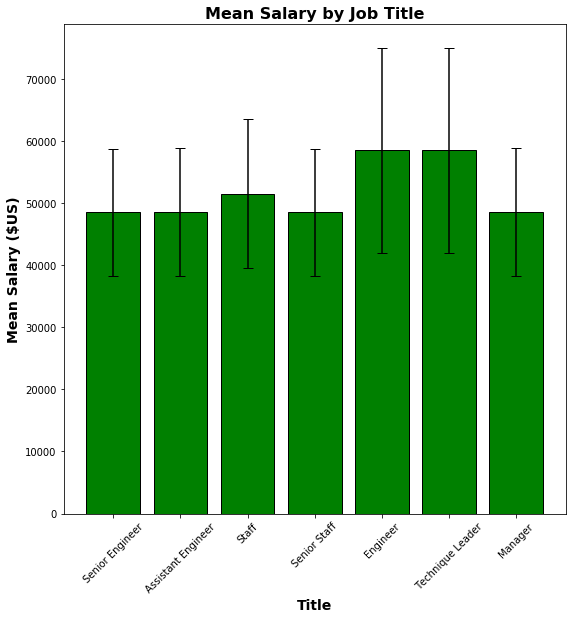

In [25]:
fig = plt.figure(figsize=(9,9))

x_axis = [i for i in range(len(means))]

plt.bar(x_axis, height = means['salary_num'], yerr = errors['salary_num'], facecolor = 'g', edgecolor = 'k', capsize = 5)
plt.xticks(x_axis, title_list, rotation=45)
plt.title('Mean Salary by Job Title', fontsize=16, fontweight='bold')
plt.xlabel('Title', fontsize = 14, fontweight='bold')
plt.ylabel('Mean Salary ($US)', fontsize = 14, fontweight='bold')

In [26]:
#data.head()
data.loc[data['emp_no'] == '499942']

,emp_no,salary,from_date,to_date,id
299966,499942,40000,3/28/1998,3/28/1999,299967


In [27]:
bonus_df.loc[bonus_df['emp_no'] == '499942']

,emp_no,salary,title,salary_num
55610,499942,40000,Technique Leader,40000


In [ ]:
#There are no real differences that I can see in pay for promotion to higher levels. Average salaries are essentially
#the same across all job titles. Also, my salary at emp_no 499942 is about as low as observable! In fact, technique leader
#and Engineer have only modestly higher average salaries, but much more variability in salaries by standard deviation.